In [1]:
import numpy as np
from tqdm.auto import trange
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib ipympl

In [7]:
def makeplot(x_source,z_source,x_dif,z_dif, x_pente, z_pente, x_surface, z_surface, dif=False, slope =False, surf=False):
    plt.figure()
    plt.plot(x_source, z_source, marker='.', markersize=3)
    if dif==True:
        plt.plot(x_dif, z_dif, marker='.', markersize=10)
    if slope == True:
        plt.plot(x_pente,z_pente, marker='.', markersize=3)
    if surf == True:
        plt.plot(x_surface,z_surface, marker='.', markersize=3)
    plt.axis('equal')


def extract_surface(path, xmax_real, xmin_real, x0_real, zmax_real, zmin_real,z0_real, lang='0'):
    '''Cette focntion permet de récupérer l'axe x et y de la surface complexe sur laquelle nous allons essayer de trouver les réflexions'''
    if lang == 'french':
        surface = pd.read_csv(path, sep=';', decimal=',')
    else:
        surface = pd.read_csv(path)
    surface = np.array(surface)
    x_surface = surface[:,0]
    z_surface = -surface[:,1]
    #maintenant on rescale toute cette mierda !!  
    #EN X 
    x_max, x_min = max(x_surface), min(x_surface)
    x_scale = (xmax_real-xmin_real)/(x_max-x_min) 
    x_surface = x_scale*x_surface
    x_surface = x_surface - x_surface[0] + x0_real #pour s'assurer que le x0 est bien à 0 comme il devrait l'être
    # EN Z
    z_max, z_min = max(z_surface), min(z_surface)
    z_scale = (zmax_real-zmin_real)/(z_max-z_min) 
    z_surface = z_scale*z_surface
    z_surface = z_surface - z_surface[0] + z0_real #pour s'assurer que le z0 est bien à -2.3 comme il devrait l'être
    return x_surface, z_surface
    
    
def model(x_source,z_source,x_dif,z_dif,x_pente,z_pente,x_surface,z_surface,dv,dmax,epsilon, name='0',x_snapshot=0,snapshot=False,export=False,dif=False, slope=False, surf=False):
    '''La focntion qui vérifie pour chaque source si chacun des points des surface conduit à un angle incident perpendiculaire à la surface (ou presque perpendiculaire; il y 
    a une tolérance nommée epsilon, plus epsilon est grand et plus il est  facile de considérer qu'une surface est perpendiculare au rai incident!!), le epsilon 
    indiqué est considéré comme étant en degrés!! ex pour epsilon = 1, un angle entre 89 et 91 degré est considéré comme étant égal à 90°.'''
    
    distance = np.linspace(0,dmax,dv)
    ds = distance[1]-distance[0] # le pas en distance, utile pour la suite, permet ensuite de trouver quel indice correcpond à quelle distance dans la matrice  
    m = np.zeros((len(distance),len(x_source))) #matrice offset distance (aka temps)
    angle_incidence_list = []
    pente_list = []
    dif_list = []
    for i in trange(len(x_source)):
        '''boucle pour la surface pentée'''
        if slope == True:
            for j in range(1,len(x_pente)-1):
                dtopo = (z_pente[j+1]-z_pente[j-1])/(x_pente[j+1]-x_pente[j-1],) #calcule la dérivée de la topo donnant la pente
                pente_topo = np.arctan(dtopo)  #calcul de l'angle en radians 
                if x_pente[j] == x_source[i]:
                    angle_incidence = np.pi/2
                else:
                    angle_incidence = np.arctan((z_pente[j]-z_source[i])/(x_pente[j]-x_source[i])) #angle d'incidence c'est pas par rapport à la topo, mais par rapport à l'axe des x 
                if abs(angle_incidence-pente_topo) <= (np.pi/2+epsilon*np.pi/180) and (angle_incidence-pente_topo) >= (np.pi/2-epsilon*np.pi/180): 
                    dist_source_surface = np.sqrt((z_pente[j]-z_source[i])**2+(x_pente[j]-x_source[i])**2)
                    dist_index = int(dist_source_surface//ds)
                    m[dist_index,i] = 1

        '''Pour le diffractant pas besoin de boucle, ça se reflète obligatoirement dessus, ez'''
        if dif == True: #condition pour mettre ou non le diffractant
            dist_source_surface = np.sqrt((z_dif-z_source[i])**2+(x_dif-x_source[i])**2)
            dist_index = int(dist_source_surface//ds)
            m[dist_index,i] = 1
            
        '''Boucle pour la surface complexe'''
        if surf == True:
            for j in range(1,len(x_surface)-1):
                dtopo = (z_surface[j+1]-z_surface[j-1])/(x_surface[j+1]-x_surface[j-1],) #calcule la dérivée de la topo donnant la pente
                pente_topo = np.arctan(dtopo)  #calcul de l'angle en radians 
                if x_surface[j] == x_source[i]:
                    angle_incidence = (np.pi/2)
                else:
                    angle_incidence = (np.arctan((z_surface[j]-z_source[i])/(x_surface[j]-x_source[i]))) #angle d'incidence c'est pas par rapport à la topo,
                #mais par rapport à l'axe des x 
                if abs(np.rad2deg(angle_incidence-pente_topo)) <= (90+epsilon) and abs(np.rad2deg(angle_incidence-pente_topo)) >= (90-epsilon): 
                    dist_source_surface = np.sqrt((z_surface[j]-z_source[i])**2+(x_surface[j]-x_source[i])**2)
                    dist_index = int(dist_source_surface//ds)
                    m[dist_index,i] = 1
        
                if snapshot==True:
                    if x_source[i]==x_snapshot: #x_snapshot est la position de la source pour laquelle on voit déterminer les angles incidents et la diff par rapport à la topo
                        #ce faisant on trouvera alors la position x des endroits où se fait la réflexion (correspond aux x pour lesquels la diff vaut 90° +/- epsilon)
                        angle_incidence_list.append(angle_incidence)
                        pente_list.append(pente_topo)
                        dif_list.append(abs(np.rad2deg(angle_incidence-pente_topo)))
    
    if snapshot==True:
        plt.figure()
        plt.plot(x_surface[1:-1],np.rad2deg(angle_incidence_list),label='incident',linewidth=0,marker='.')
        plt.plot(x_surface[1:-1],np.rad2deg(pente_list), label='pente',linewidth=0,marker='.')
        plt.plot(x_surface[1:-1],dif_list, label='diff',linewidth=0,marker='.')
        plt.plot(x_surface, np.ones(len(x_surface))*(90-epsilon), linestyle='dashed', color='black')
        plt.plot(x_surface, np.ones(len(x_surface))*(90+epsilon), linestyle='dashed', color='black')
        plt.legend()
    
    plt.figure()
    plt.pcolormesh(x_source,distance,m)
    plt.minorticks_on()
    plt.grid(alpha=0.5,linestyle='dashed', which='major')
    plt.grid(alpha=0.15, linestyle='dashed', which='minor')
    ax = plt.gca()
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.set_adjustable('box')
    plt.ylabel('Time A.U.')
    plt.title('Predicted travel times for reflected waves using the zero-offset method')
    plt.axis('scaled')
    if export==True:
        plt.savefig(name,dpi=600)

# Ex 1

### Configuration 1

  0%|          | 0/372 [00:00<?, ?it/s]

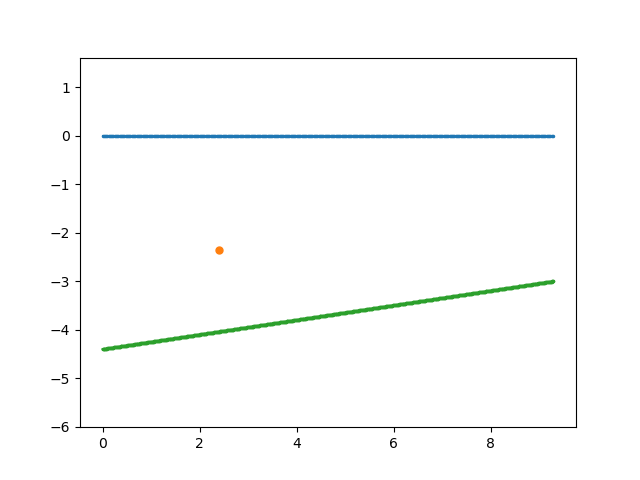

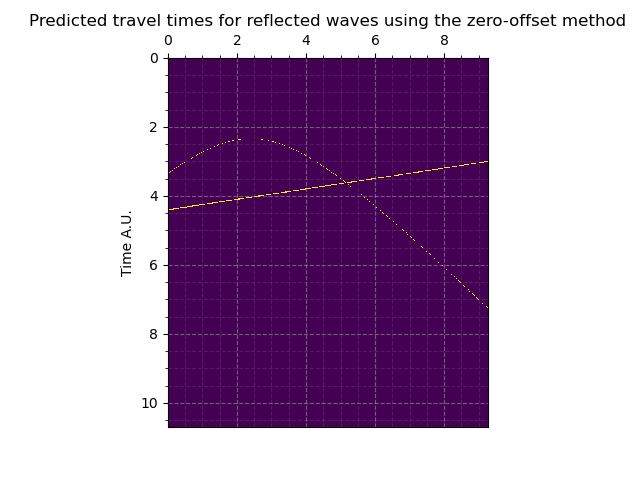

In [3]:
x_surface, z_surface = extract_surface('config2.csv', 9.3, 0, 0, -1.8,-3.25,-3.25)
x_source = np.arange(0,9.3,0.025)
z_source = np.zeros(len(x_source)) 
x_dif = 2.4
z_dif = -2.35
x_pente = np.arange(0,9.3,0.01) 
z_pente = np.linspace(-4.4,-3,len(x_pente))
                        
dv = 1000  #nombre de points de temps/distance  
dmax = 10.7#distance max pouvant être traversée entre un récepteur et le point le plus loin, afin de scale correctement l'axe du temps  
epsilon = 10

dif = True
slope = True
surf = False
makeplot(x_source,z_source,x_dif,z_dif,x_pente,z_pente, x_surface, z_surface, dif=dif,slope=slope,surf=surf)
model(x_source,z_source,x_dif,z_dif,x_pente,z_pente,x_surface,z_surface,dv,dmax,epsilon, dif=dif, slope=slope, surf=surf)

### Configuration 2

  0%|          | 0/372 [00:00<?, ?it/s]

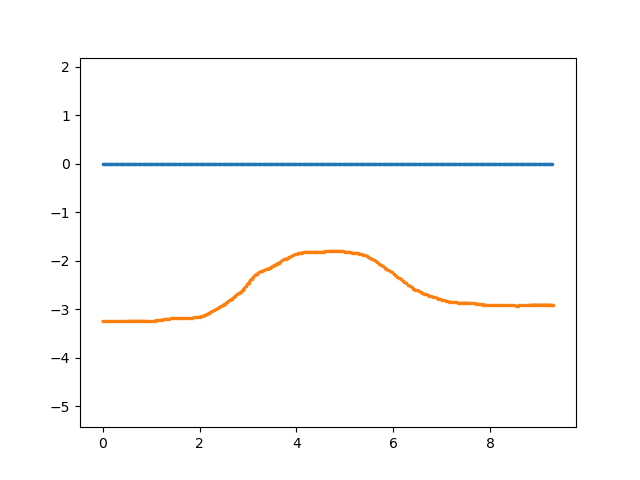

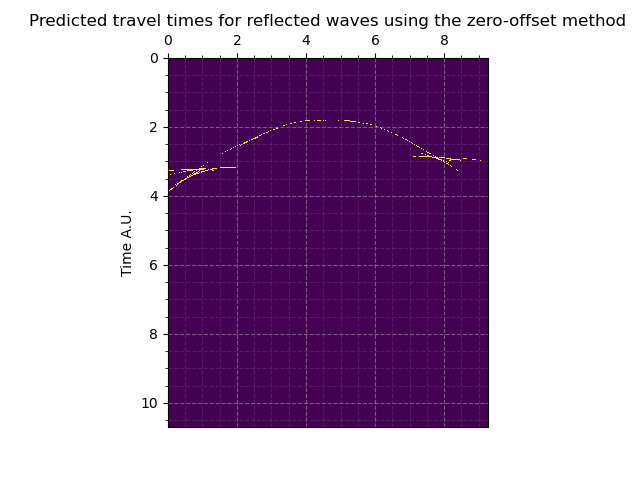

In [4]:
x_source = np.arange(0,9.3,0.025)
z_source = np.zeros(len(x_source)) 
x_surface, z_surface = extract_surface('config2.csv', 9.3, 0, 0, -1.8,-3.25,-3.25)


dv = 1000  #nombre de points de temps/distance  
dmax = 10.7#distance max pouvant être traversée entre un récepteur et le point le plus loin, afin de scale correctement l'axe du temps  
epsilon = 3

dif = False
slope = False
surf = True
makeplot(x_source,z_source,x_dif,z_dif,x_pente,z_pente, x_surface, z_surface, dif=dif,slope=slope,surf=surf)
model(x_source,z_source,x_dif,z_dif,x_pente,z_pente,x_surface,z_surface,dv,dmax,epsilon,x_snapshot=0.5,snapshot=False, dif=dif, slope=slope, surf=surf)


### Configuration 3

  0%|          | 0/372 [00:00<?, ?it/s]

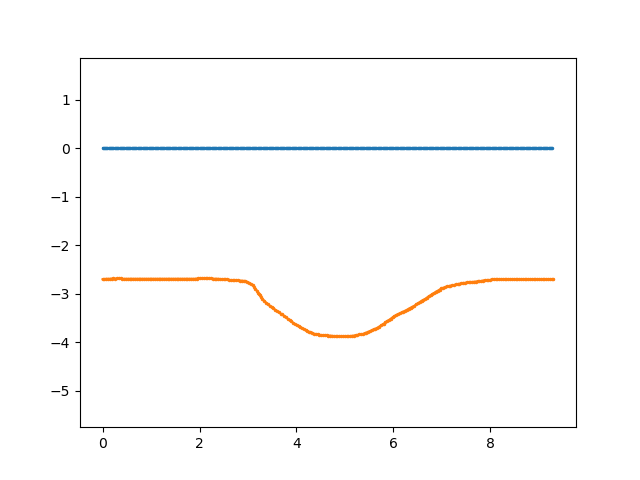

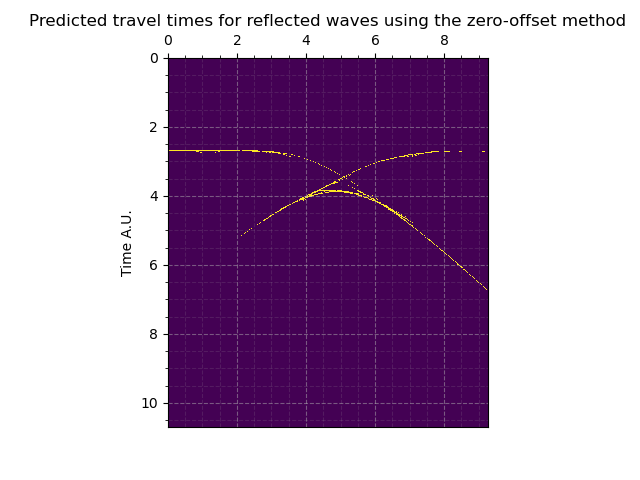

In [5]:
x_source = np.arange(0,9.3,0.025)
z_source = np.zeros(len(x_source)) 
x_surface, z_surface = extract_surface('config3.csv', 9.3, 0, 0, -2.7,-3.9,-2.7)

dv = 1000  #nombre de points de temps/distance  
dmax = 10.7#distance max pouvant être traversée entre un récepteur et le point le plus loin, afin de scale correctement l'axe du temps  
epsilon = 5

dif = False
slope = False
surf = True
makeplot(x_source,z_source,x_dif,z_dif,x_pente,z_pente, x_surface, z_surface, dif=dif,slope=slope,surf=surf)
model(x_source,z_source,x_dif,z_dif,x_pente,z_pente,x_surface,z_surface,dv,dmax,epsilon,x_snapshot=2,snapshot=False, dif=dif, slope=slope, surf=surf)


# Homework

  0%|          | 0/372 [00:00<?, ?it/s]

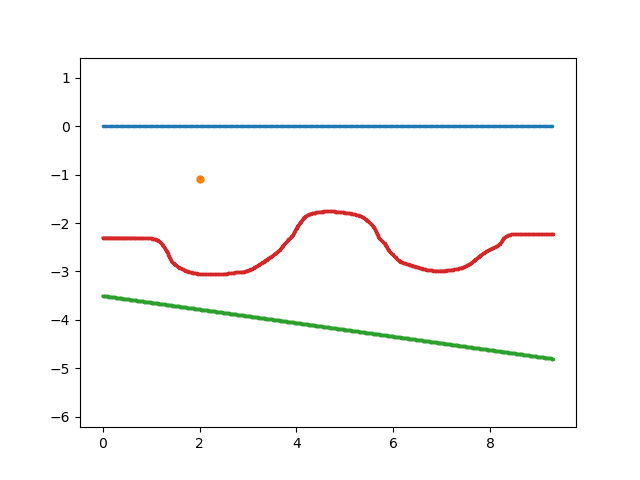

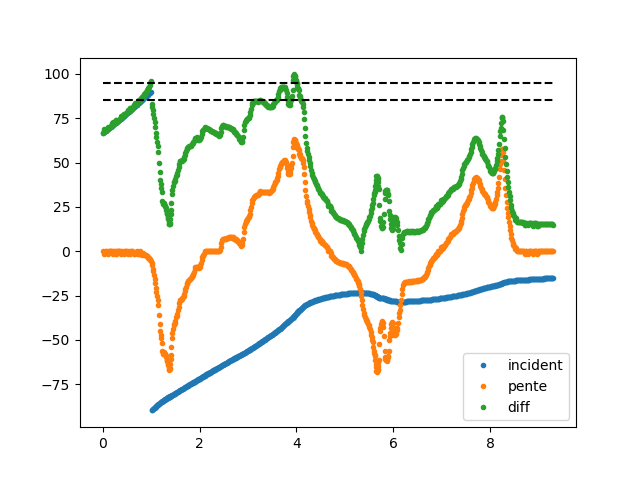

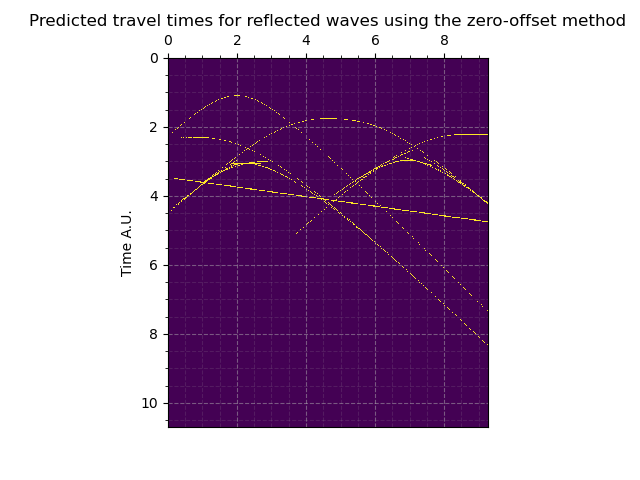

In [8]:
x_source = np.arange(0,9.3,0.025)
z_source = np.zeros(len(x_source)) 
x_dif = 2
z_dif = -1.1
x_pente = np.arange(0,9.3,0.01) 
z_pente = np.linspace(-3.5,-4.8,len(x_pente))
x_surface, z_surface = extract_surface('HW_10px.csv', 9.3, 0, 0, -1.8,-3.1,-2.3)
    
dv = 1000  #nombre de points de temps/distance  
dmax = 10.7#distance max pouvant être traversée entre un récepteur et le point le plus loin, afin de scale correctement l'axe du temps  
epsilon = 5

dif = True
slope = True
surf = True
makeplot(x_source,z_source,x_dif,z_dif,x_pente,z_pente, x_surface, z_surface, dif=dif,slope=slope,surf=surf)
model(x_source,z_source,x_dif,z_dif,x_pente,z_pente,x_surface,z_surface,dv,dmax,epsilon,name='HW.png',x_snapshot=1,snapshot=True,export=True, dif=dif, slope=slope, surf=surf)